# Deep Learning to Predict Delayed Flights in Tableau 

In [2]:

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, metrics, svm, ensemble
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, fbeta_score

import keras
import pickle
from keras_pickle_wrapper import KerasPickleWrapper 
import tabpy
import tabpy_client
from tabpy.tabpy_tools.client import Client


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [4]:
# load data
df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


## EDA

In [5]:
# inspect cancelled flights
df[df['CANCELLED'] != 0.0]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
179,2016,1,1,10,7,DL,N924DN,86,13487,MSP,...,1632,NaN,NaN,NaN,1.0,0.0,104.0,NaN,528.0,NaN
210,2016,1,1,10,7,DL,N951DN,1096,11433,DTW,...,1303,NaN,NaN,NaN,1.0,0.0,123.0,NaN,528.0,NaN
478,2016,1,1,22,5,DL,N387DA,1542,14747,SEA,...,723,NaN,NaN,NaN,1.0,0.0,318.0,NaN,2422.0,NaN
481,2016,1,1,22,5,DL,N960AT,1795,10397,ATL,...,2014,NaN,NaN,NaN,1.0,0.0,149.0,NaN,760.0,NaN
491,2016,1,1,22,5,DL,N972AT,2312,13487,MSP,...,2149,NaN,NaN,NaN,1.0,0.0,174.0,NaN,1029.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10619,2016,4,12,11,7,DL,N838DN,1747,11433,DTW,...,1754,NaN,NaN,NaN,1.0,0.0,309.0,NaN,1927.0,NaN
10625,2016,4,12,12,1,DL,N838DN,38,14747,SEA,...,1655,NaN,NaN,NaN,1.0,0.0,260.0,NaN,1927.0,NaN
10756,2016,4,12,17,6,DL,N995DL,220,12478,JFK,...,2212,NaN,NaN,NaN,1.0,0.0,167.0,NaN,760.0,NaN
10785,2016,4,12,18,7,DL,N995DL,42,10397,ATL,...,1743,NaN,NaN,NaN,1.0,0.0,143.0,NaN,760.0,NaN


In [6]:
# inspect diverted flights
df[df['DIVERTED'] != 0.0]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
177,2016,1,1,9,6,DL,N3743H,2834,13487,MSP,...,852,1151.0,NaN,NaN,0.0,1.0,231.0,NaN,1399.0,NaN
184,2016,1,1,10,7,DL,N922DX,557,13487,MSP,...,912,1500.0,NaN,NaN,0.0,1.0,107.0,NaN,528.0,NaN
581,2016,1,1,25,1,DL,N389DA,1187,13487,MSP,...,1928,2239.0,NaN,NaN,0.0,1.0,229.0,NaN,1399.0,NaN
868,2016,1,2,2,2,DL,N589NW,2794,11433,DTW,...,946,1147.0,NaN,NaN,0.0,1.0,146.0,NaN,594.0,NaN
997,2016,1,2,9,2,DL,N382DA,281,11433,DTW,...,1100,1322.0,NaN,NaN,0.0,1.0,320.0,NaN,1927.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,2016,4,11,18,5,DL,N363NW,87,11433,DTW,...,1658,2013.0,NaN,NaN,0.0,1.0,123.0,NaN,528.0,NaN
10181,2016,4,11,30,3,DL,N952DN,2830,13487,MSP,...,1447,2251.0,NaN,NaN,0.0,1.0,153.0,NaN,907.0,NaN
10557,2016,4,12,8,4,DL,N3761R,2649,10397,ATL,...,1059,1327.0,NaN,NaN,0.0,1.0,119.0,NaN,594.0,NaN
10618,2016,4,12,11,7,DL,N838DN,1734,13487,MSP,...,1436,1850.0,NaN,NaN,0.0,1.0,101.0,NaN,528.0,NaN


In [7]:
df.shape

(11231, 26)

In [8]:
df.isnull().values.any()

True

In [9]:
df.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [10]:
df = df.drop('Unnamed: 25', axis=1)

In [11]:
df[df.isnull().values.any(axis=1)]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
177,2016,1,1,9,6,DL,N3743H,2834,13487,MSP,...,0.0,852,1151.0,NaN,NaN,0.0,1.0,231.0,NaN,1399.0
179,2016,1,1,10,7,DL,N924DN,86,13487,MSP,...,NaN,1632,NaN,NaN,NaN,1.0,0.0,104.0,NaN,528.0
184,2016,1,1,10,7,DL,N922DX,557,13487,MSP,...,0.0,912,1500.0,NaN,NaN,0.0,1.0,107.0,NaN,528.0
210,2016,1,1,10,7,DL,N951DN,1096,11433,DTW,...,NaN,1303,NaN,NaN,NaN,1.0,0.0,123.0,NaN,528.0
478,2016,1,1,22,5,DL,N387DA,1542,14747,SEA,...,NaN,723,NaN,NaN,NaN,1.0,0.0,318.0,NaN,2422.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10625,2016,4,12,12,1,DL,N838DN,38,14747,SEA,...,NaN,1655,NaN,NaN,NaN,1.0,0.0,260.0,NaN,1927.0
10746,2016,4,12,16,5,DL,N965AT,438,12478,JFK,...,1.0,1824,2309.0,NaN,NaN,0.0,1.0,204.0,NaN,1029.0
10756,2016,4,12,17,6,DL,N995DL,220,12478,JFK,...,1.0,2212,NaN,NaN,NaN,1.0,0.0,167.0,NaN,760.0
10785,2016,4,12,18,7,DL,N995DL,42,10397,ATL,...,NaN,1743,NaN,NaN,NaN,1.0,0.0,143.0,NaN,760.0


## Feature Engineering

In [12]:
# fill in NAs with 1 as INT
df = df.fillna({'ARR_DEL15': 1})
df['ARR_DEL15'] = df['ARR_DEL15'].astype(int)
df.iloc[177:185]

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
177,2016,1,1,9,6,DL,N3743H,2834,13487,MSP,...,0.0,852,1151.0,NaN,1,0.0,1.0,231.0,NaN,1399.0
178,2016,1,1,9,6,DL,N975AT,2839,11433,DTW,...,0.0,1724,1709.0,-15.0,0,0.0,0.0,117.0,106.0,509.0
179,2016,1,1,10,7,DL,N924DN,86,13487,MSP,...,NaN,1632,NaN,NaN,1,1.0,0.0,104.0,NaN,528.0
180,2016,1,1,10,7,DL,N671DN,87,11433,DTW,...,1.0,1649,1703.0,14.0,0,0.0,0.0,129.0,119.0,528.0
181,2016,1,1,10,7,DL,N319NB,423,12478,JFK,...,0.0,1600,1607.0,7.0,0,0.0,0.0,155.0,151.0,760.0
182,2016,1,1,10,7,DL,N587NW,440,12478,JFK,...,0.0,849,835.0,-14.0,0,0.0,0.0,159.0,146.0,760.0
183,2016,1,1,10,7,DL,N813DN,485,12478,JFK,...,1.0,1945,1955.0,10.0,0,0.0,0.0,390.0,335.0,2422.0
184,2016,1,1,10,7,DL,N922DX,557,13487,MSP,...,0.0,912,1500.0,NaN,1,0.0,1.0,107.0,NaN,528.0


In [13]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,0.0,2143,2102.0,-41.0,0,0.0,0.0,338.0,295.0,2182.0
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,0.0,1435,1439.0,4.0,0,0.0,0.0,110.0,115.0,528.0
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,0.0,1215,1142.0,-33.0,0,0.0,0.0,335.0,300.0,2182.0
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,0.0,1335,1345.0,10.0,0,0.0,0.0,196.0,205.0,1399.0
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,0.0,607,615.0,8.0,0,0.0,0.0,247.0,259.0,1927.0


In [14]:
# bin the times of day hourly
for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,DEP_DEL15,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,0.0,2143,2102.0,-41.0,0,0.0,0.0,338.0,295.0,2182.0
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,0.0,1435,1439.0,4.0,0,0.0,0.0,110.0,115.0,528.0
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,0.0,1215,1142.0,-33.0,0,0.0,0.0,335.0,300.0,2182.0
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,0.0,1335,1345.0,10.0,0,0.0,0.0,196.0,205.0,1399.0
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,0.0,607,615.0,8.0,0,0.0,0.0,247.0,259.0,1927.0


## Feature Selection and Pre Processing

In [15]:
# save data to upload to tableau
df.to_csv('flight_delays_clean.csv')

In [16]:
# select feeatures
delay_df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
delay_df.isnull().sum()

MONTH           0
DAY_OF_MONTH    0
DAY_OF_WEEK     0
ORIGIN          0
DEST            0
CRS_DEP_TIME    0
ARR_DEL15       0
dtype: int64

In [17]:
# get dummies for machine learning algorithms
delay_df = pd.get_dummies(delay_df, columns=['ORIGIN', 'DEST'])
delay_df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0,0,0,0,0,1,0,1,0,0,0


In [18]:
# subset the entire data for deep learning deployment
deep_df = delay_df.copy()
x = deep_df.drop('ARR_DEL15', axis=1)
y = deep_df['ARR_DEL15']

## Split and Scale

In [19]:
# stratify split to better handle class imbalances
x_train, x_test, y_train, y_test = train_test_split(delay_df.drop('ARR_DEL15', axis=1), delay_df['ARR_DEL15'], 
                                                    test_size=0.20, stratify=delay_df['ARR_DEL15'], random_state=42)

In [20]:
Counter(y_train)

Counter({1: 1250, 0: 7734})

In [21]:
Counter(y_test)

Counter({0: 1934, 1: 313})

In [22]:
# weight each class for class imbalances in deep learning
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 1250 (13.91% of total)


In [23]:
weight_for_0 

0.00012929919834497026

In [24]:
weight_for_1

0.0008

In [25]:
# scale the data
#scaler = preprocessing.StandardScaler().fit(x_train)
#scaler = preprocessing.MinMaxScaler().fit(x_train)
#x_train = scaler.transform(x_train)

## Random Forest Classifier

In [26]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [27]:
# Show classification report for the best model (set of parameters) run over the full dataset
print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1934
           1       0.57      0.14      0.22       313

    accuracy                           0.87      2247
   macro avg       0.72      0.56      0.57      2247
weighted avg       0.83      0.87      0.83      2247



In [28]:
# Show accuracy and area under ROC curve
print("Accuracy: %0.3f" % accuracy_score(y_test, y_pred, normalize=True))
print("Aucroc: %0.3f" % metrics.roc_auc_score(y_test, y_pred))
print("")

Accuracy: 0.866
Aucroc: 0.560



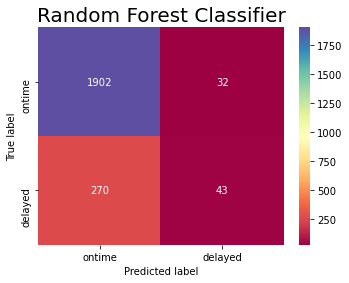

True Negatives:  1902
False Positives:  32
False Negatives:  270
True Positives:  43


In [29]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['ontime','delayed'], 
                     columns = ['ontime','delayed'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Spectral', fmt='d')
plt.title('Random Forest Classifier', fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

## Logistic Regression

In [30]:
# Logistic regression with 10 fold stratified cross-validation using model specific cross-validation in scikit-learn

lgclf = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))),penalty='l2',scoring='roc_auc',cv=10)

lgclf.fit(x_train, y_train)

y_pred = lgclf.predict(x_test)

In [31]:
# Show classification report 
print("Classification report:")
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1934
           1       0.00      0.00      0.00       313

    accuracy                           0.86      2247
   macro avg       0.43      0.50      0.46      2247
weighted avg       0.74      0.86      0.80      2247



In [32]:

# Show accuracy and area under ROC curve
print("Accuracy: %0.3f" % accuracy_score(y_test, y_pred, normalize=True))
print("Aucroc: %0.3f" % metrics.roc_auc_score(y_test, y_pred))

Accuracy: 0.861
Aucroc: 0.500


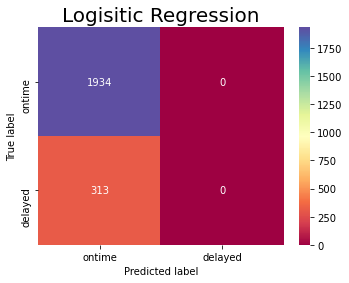

True Negatives:  1934
False Positives:  0
False Negatives:  313
True Positives:  0


In [33]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['ontime','delayed'], 
                     columns = ['ontime','delayed'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Spectral', fmt='d')
plt.title('Logisitic Regression', fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

## Naive Bayes

In [34]:
# Naive Bayes with 10 fold stratified cross-validation
nbclf = GaussianNB()
scores = cross_val_score(nbclf, x_train, y_train, cv=10, scoring='roc_auc')

# Show accuracy statistics for cross-validation
print("Accuracy: %0.3f" % (scores.mean()))
print("Aucroc: %0.3f" % metrics.roc_auc_score(y_test, cross_val_predict(nbclf, x_test, y_test, cv=10)))

Accuracy: 0.582
Aucroc: 0.516


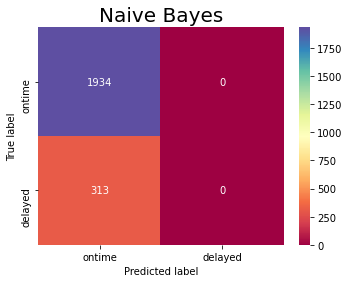

True Negatives:  1934
False Positives:  0
False Negatives:  313
True Positives:  0


In [35]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['ontime','delayed'], 
                     columns = ['ontime','delayed'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Spectral', fmt='d')
plt.title('Naive Bayes', fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

## Gradient Boosting Classifier

In [36]:
# Define the parameter grid to use for tuning the Gradient Boosting Classifier
gridparams = dict(learning_rate=[0.01, 0.1],loss=['deviance','exponential'])

# Parameters we're not tuning for this classifier
params = {'n_estimators': 1500, 'max_depth': 4}

# Setup for grid search with cross-validation for Gradient Boosting Classifier
# n_jobs=-1 for parallel execution using all available cores
gbclf = GridSearchCV(ensemble.GradientBoostingClassifier(**params), gridparams, cv=10, scoring='roc_auc',n_jobs=-1)
gbclf.fit(x_train, y_train)

# Show the definition of the best model
print("Best model:")
print(gbclf.best_estimator_)
print("")

# Show classification report for the best model (set of parameters) run over the full dataset
print("Classification report:")    
y_pred = gbclf.predict(x_test)
print(classification_report(y_test, y_pred))

# Show accuracy and area under ROC curve
print("Accuracy: %0.3f" % accuracy_score(y_test, y_pred, normalize=True))
print("Aucroc: %0.3f" % metrics.roc_auc_score(y_test, y_pred))

Best model:
GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=1500)

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1934
           1       0.70      0.13      0.23       313

    accuracy                           0.87      2247
   macro avg       0.79      0.56      0.58      2247
weighted avg       0.85      0.87      0.83      2247

Accuracy: 0.871
Aucroc: 0.562


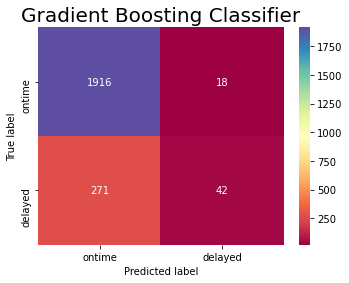

True Negatives:  1916
False Positives:  18
False Negatives:  271
True Positives:  42


In [37]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['ontime','delayed'], 
                     columns = ['ontime','delayed'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Spectral', fmt='d')
plt.title('Gradient Boosting Classifier', fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

## Keras Deep Learning - Train and Test

In [38]:
test_model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.01),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
test_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3840      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 135,681
Trainable params:

In [39]:
def FindBatchSize(model):
    """model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(test_model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound


FindBatchSize(test_model)

Batch Size:  64


64

In [40]:
metrics = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

test_model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("delay_test_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

test_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    verbose=0,
    callbacks=callbacks,
    validation_split = 0.2,
   class_weight=class_weight,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [41]:

# Evaluate your model accuracy on the test set

accuracy_score = test_model.evaluate(x_test, y_test)

print("Binary Crossentropy: %0.3f" % (accuracy_score[0]))
print("Accuracy: %0.3f" % (accuracy_score[1]))
print("Precision: %0.3f" % (accuracy_score[6]))
print("Recall: %0.3f" % (accuracy_score[7]))
print("AUC: %0.3f" % (accuracy_score[8]))


2247/2247 [==============================] - 0s 21us/step
Binary Crossentropy: 0.682
Accuracy: 0.673
Precision: 0.205
Recall: 0.470
AUC: 0.601


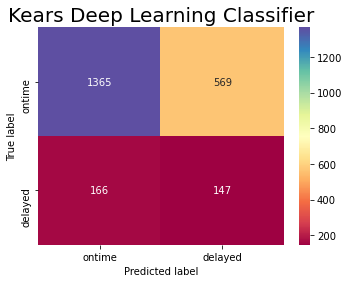

True Negatives:  1916
False Positives:  18
False Negatives:  271
True Positives:  42


In [42]:
cm = np.array([[accuracy_score[4], accuracy_score[3]], [accuracy_score[2], accuracy_score[5]]])

cm_df = pd.DataFrame(cm,
                     index = ['ontime','delayed'], 
                     columns = ['ontime','delayed'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, cmap='Spectral', fmt='g')
plt.title('Kears Deep Learning Classifier', fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [43]:
keras.backend.clear_session()

## Keras Deep Learning - Full Model

In [44]:
# weaight each class for class imbalances
counts = np.bincount(y)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 1563 (13.92% of total)


In [45]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(x.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.01),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3840      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 135,681
Trainable params: 135,681
Non-trainable params: 0
________________________________________________

In [46]:

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy"
)

callbacks = [keras.callbacks.ModelCheckpoint("delay_model_at_epoch_{epoch}.h5")]
class_weight = {0: weight_for_0, 1: weight_for_1}

kpw = KerasPickleWrapper(model)

kpw().fit(
    x,
    y,
    batch_size=64,
    epochs=100,
    verbose=0,
    callbacks=callbacks,
    validation_split = 0.2,
   class_weight=class_weight,
)


## Deploy Model to Tableau with TabPy

In [47]:
client = tabpy_client.Client('http://localhost:9004/')

In [48]:

def PredictDelay(_arg1, _arg2, _arg3, _arg4, _arg5, _arg6):
    
    import pandas as pd
    
    #handle dummy variable assignments
    ORIGIN_ATL = 1 if _arg4[0] == 'ATL' else 0
    ORIGIN_DTW = 1 if _arg4[0] == 'DTW' else 0
    ORIGIN_JFK = 1 if _arg4[0] == 'JFK' else 0
    ORIGIN_MSP = 1 if _arg4[0] == 'MSP' else 0
    ORIGIN_SEA = 1 if _arg4[0] == 'SEA' else 0

    DEST_ATL = 1 if _arg5[0] == 'ATL' else 0
    DEST_DTW = 1 if _arg5[0] == 'DTW' else 0
    DEST_JFK = 1 if _arg5[0] == 'JFK' else 0
    DEST_MSP = 1 if _arg5[0] == 'MSP' else 0
    DEST_SEA = 1 if _arg5[0] == 'SEA' else 0
    
    # create a data dictionary
    row = {'MONTH': _arg1,
           'DAY_OF_MONTH': _arg2,
           'DAY_OF_WEEK': _arg3,
           'CRS_DEP_TIME': _arg6,
           
           'ORIGIN_ATL': ORIGIN_ATL,
           'ORIGIN_DTW': ORIGIN_DTW,
           'ORIGIN_JFK': ORIGIN_JFK,
           'ORIGIN_MSP': ORIGIN_MSP,
           'ORIGIN_SEA': ORIGIN_SEA,
           
           'DEST_ATL': DEST_ATL,
           'DEST_DTW': DEST_DTW,
           'DEST_JFK': DEST_JFK,
           'DEST_MSP': DEST_MSP,
           'DEST_SEA': DEST_SEA,
           }

    # convert it into a dataframe
    X = pd.DataFrame(data = row, index=[0]) 


    # return prediction as a string since float32 cannot be serialized
    return str(kpw().predict(X)[0][0])    


In [49]:
# Publish the PredictDelay function to TabPy server so it can be used from Tableau
client.deploy('PredictDelay',
                  PredictDelay,
                  'Returns the probability of a delayed flight', override = True)

In [50]:
# testing
kpw().predict(np.column_stack([5, 5, 5, 16, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]))[0][0]

0.43197033

In [51]:
keras.backend.clear_session()
